# Dropped Tarots

## Problem statement

Oops! I dropped some tarot cards into a box of pixels. Can you help me retrieve them?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
!curl https://storage.googleapis.com/aiolympiadmy/ioai-2025-tsp/ioai2025_tsp_selection2/dropped_tarots/dropped_tarots.npy -o dropped_tarots.npy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 3037k  100 3037k    0     0  4548k      0 --:--:-- --:--:-- --:--:-- 4574k


In [3]:
X = np.load("dropped_tarots.npy")

In [4]:
def visualize_pointcloud(pointcloud, elev=30, azim=30, s=20):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Extract spatial and color data
    x = pointcloud[:, 0]
    y = pointcloud[:, 1]
    z = pointcloud[:, 2]
    colors = pointcloud[:, 3:6]

    scatter = ax.scatter(x, y, z, c=colors, s=s)

    # Set axis labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Set view angle
    ax.view_init(elev=elev, azim=azim)

    # Set equal aspect ratio
    ax.set_box_aspect([1, 1, 1])

    plt.tight_layout()
    plt.show()

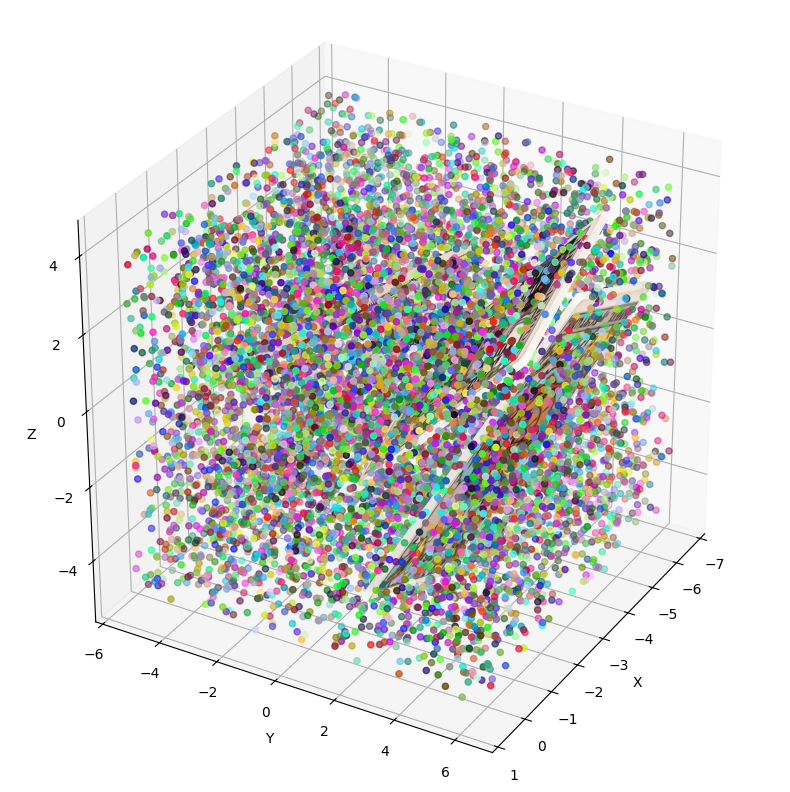

In [5]:
visualize_pointcloud(X)

Here is how your work will be scored:

- 1 pt awarded for demonstrating every single card retrieved from the box, and plotted in notebook as individual images. All cards need to be **upright**. The card labels should be directly readeable without requiring us to tilt our heads. 
- 1 pt awarded for demonstrating every single card retrieved from the box, plotted in notebook as individual images and show that they are **perfectly upright**.
- 1 pt awarded for demonstrating every single card retrieved from the box, plotted in notebook as individual images and have them be perfectly upright and are **noise-free**.
- 2 pts awarded for reconstructing the original scene above, excluding noise. You must start from your own retrieved images that are in 2D, and arrive at a tensor with similar dimensions as the orignal `dropped_tarot.npy` albeit with different length. Capped to 1 pt only if your retrieved images are not perfectly upright and are not perfectly noise-free.
- 1 pt awarded for explaining your thought process and reasoning for your work done. Keep it brief, one short paragraph is enough!

Partial credit to be granted at discretion.

Definitions:

- Upright means:
    - the card is oriented correctly with label at the bottom, and
    - the letters of the label are in correct left to right order, and
    - the card should have <= 20 degrees rotation.
- Perfectly upright means in addition to the definition of upright above, each image should have exactly zero rotation, and thus have exactly the same dimensions as the original image. 
- No noise means each image does not contain any noise pixels, and only contains identical pixel values as the original image.

## Your work below

In [6]:
# Read everything clearly before you start!
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import HDBSCAN

### Seperate the cards

In [7]:
def compute_mean_distances(X):
    nbrs = NearestNeighbors(n_neighbors=10).fit(X)
    distances, _ = nbrs.kneighbors(X)
    mean_distances = distances[:, 1:].mean(axis=1)
    return mean_distances

In [8]:
mean_distances = compute_mean_distances(X[:, :3])
mean_distances

array([0.05466635, 0.05466635, 0.05402711, ..., 0.38295847, 0.52000079,
       0.51379249])

(array([5.4281e+04, 2.5200e+02, 2.7500e+02, 8.2900e+02, 3.2980e+03,
        3.8310e+03, 1.5970e+03, 3.6200e+02, 6.4000e+01, 1.1000e+01]),
 array([0.0466459 , 0.11799111, 0.18933631, 0.26068151, 0.33202671,
        0.40337191, 0.47471711, 0.54606231, 0.61740751, 0.68875271,
        0.76009792]),
 <BarContainer object of 10 artists>)

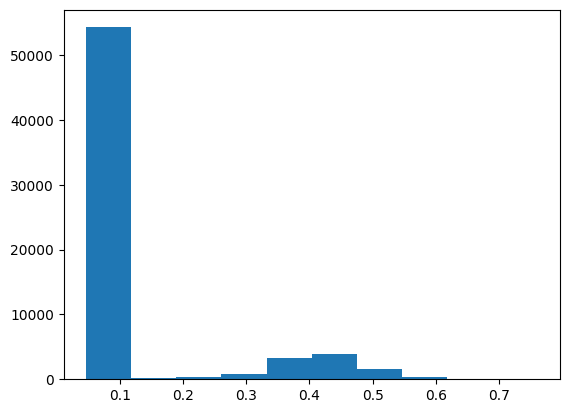

In [9]:
plt.hist(mean_distances)

In [10]:
def denoise(X, dist, threshold):
    return X[dist < threshold]

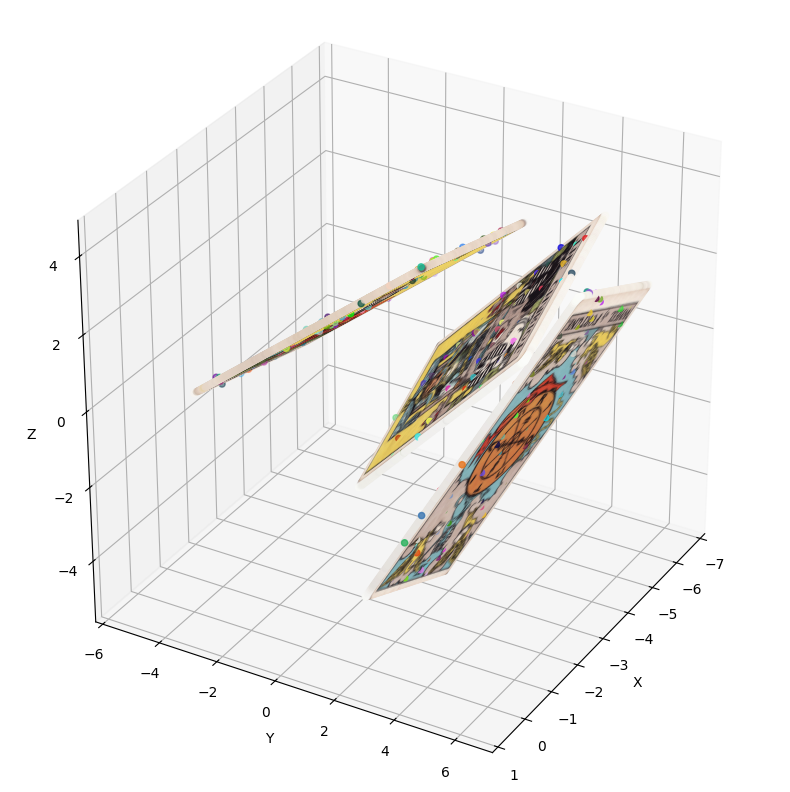

In [11]:
X_cleaned = denoise(X, mean_distances, 0.12)  # Taken from the bins above
visualize_pointcloud(X_cleaned)

In [12]:
hdb = HDBSCAN()
tarot_idx = hdb.fit_predict(X_cleaned)
tarot_idx, np.unique(tarot_idx)

(array([1, 1, 0, ..., 1, 0, 0], dtype=int64),
 array([-1,  0,  1,  2], dtype=int64))

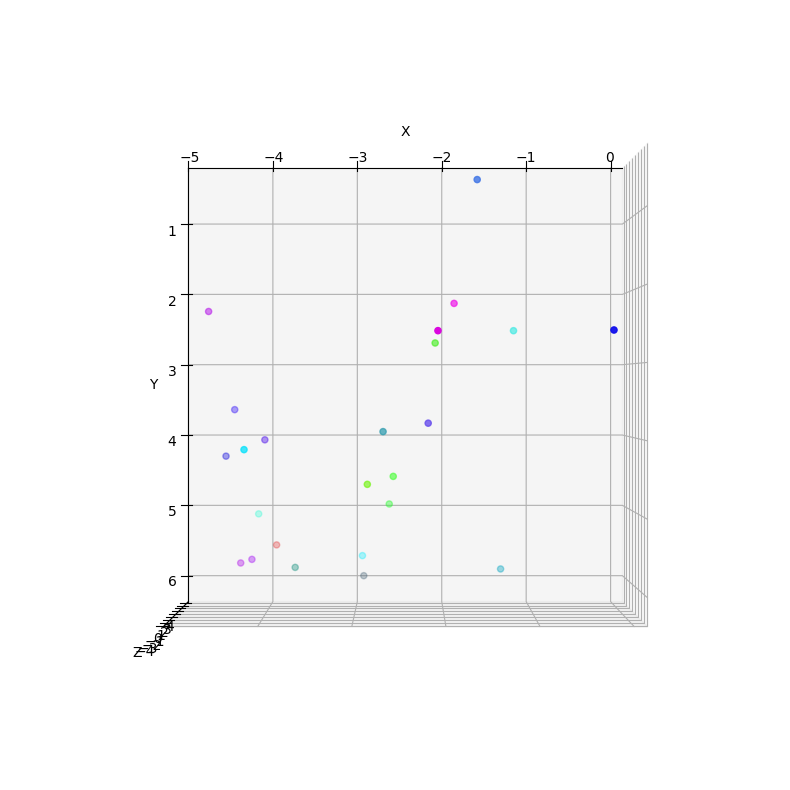

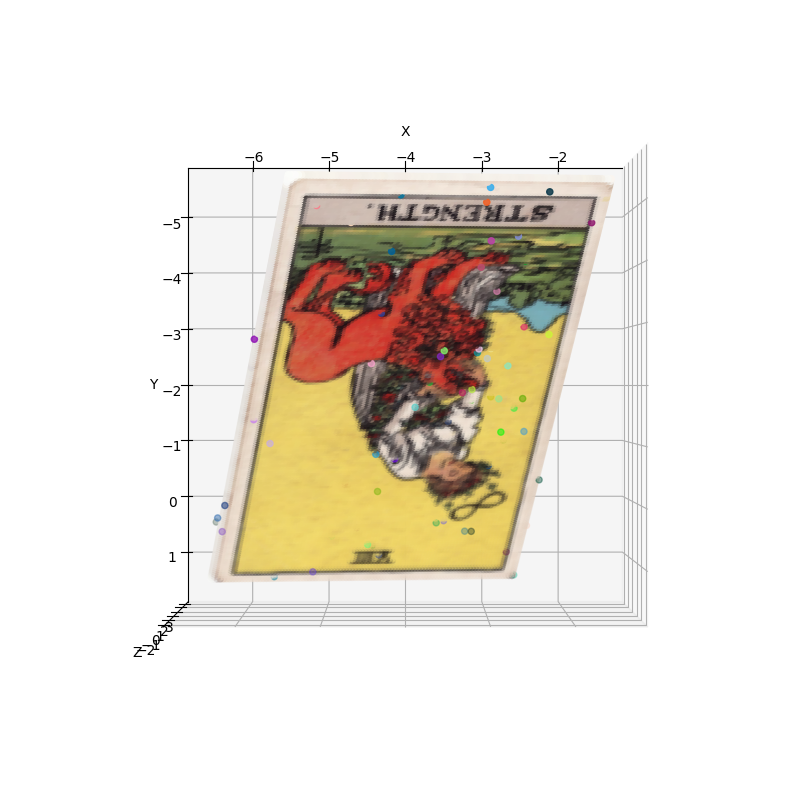

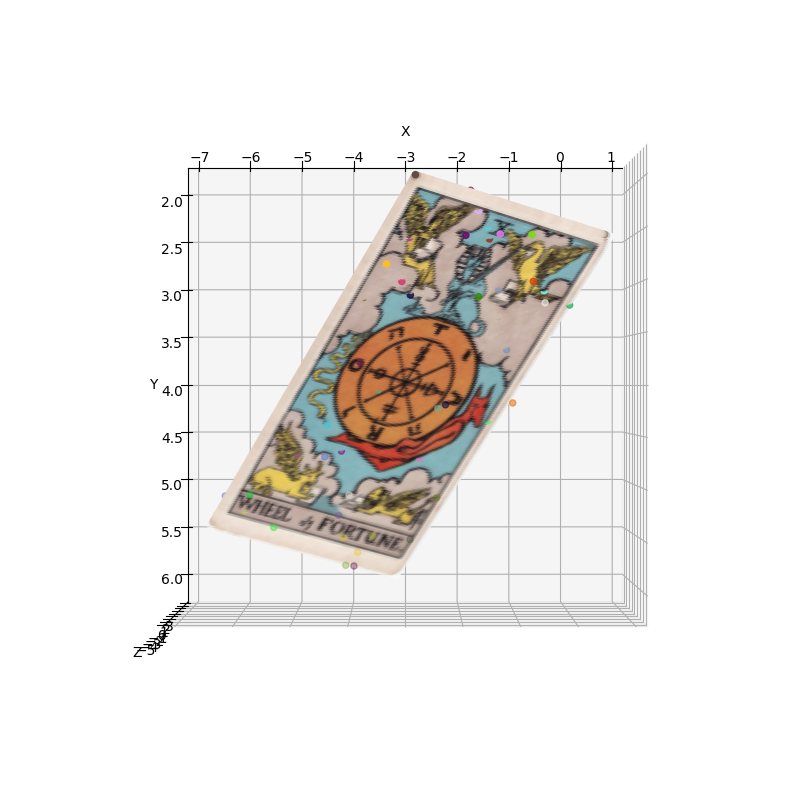

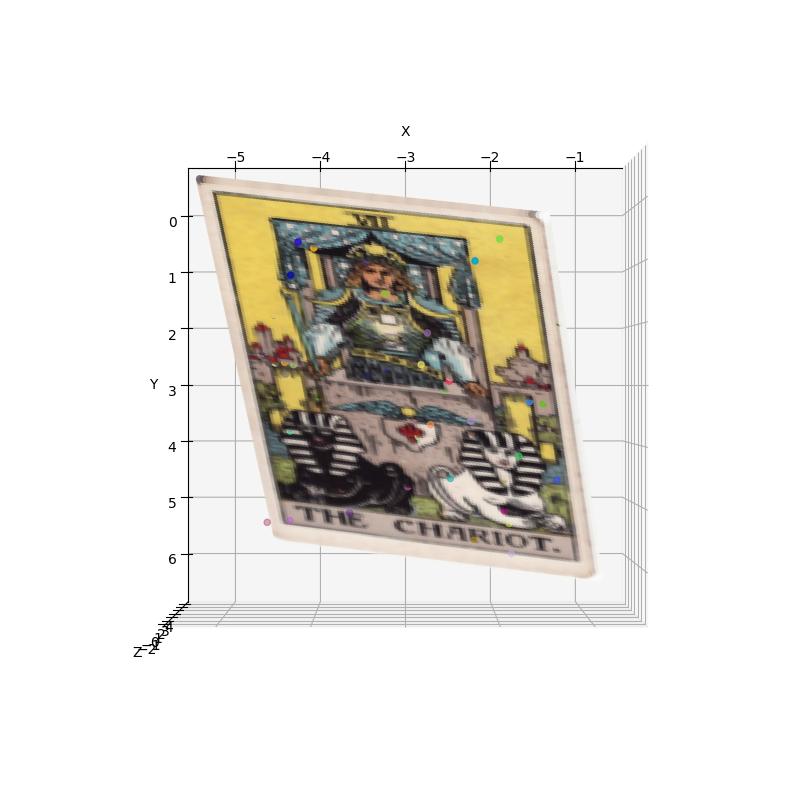

In [13]:
for i in np.unique(tarot_idx):
    visualize_pointcloud(X_cleaned[tarot_idx == i], -90, -90)

In [14]:
tarots = [X_cleaned[tarot_idx == i] for i in range(3)]

### Regress plane parameters

In [15]:
from sklearn.linear_model import LinearRegression

In [16]:
def regress_plane(xy, z):
    lr = LinearRegression()
    lr.fit(xy, z)

    return *lr.coef_, lr.intercept_  # Return (a, b, c), such that z = ax + by + c

In [17]:
planes = [regress_plane(tarots[i][:, :2], tarots[i][:, 2]) for i in range(len(tarots))]
planes

[(0.26789816917551396, 0.6469182091040637, 2.8654156551808834),
 (0.21821938166285687, 2.020653924188945, -8.427935842275843),
 (-0.5103626460551992, 0.9114521680495496, -3.26546129807692)]

In [18]:
for idx, tarot in enumerate(tarots):
    a, b, c = planes[idx]

    x, y, z = tarot[:, 0], tarot[:, 1], tarot[:, 2]
    mask = np.isclose(z, a * x + b * y + c, atol=5e-4)
    tarots[idx] = tarot[mask]

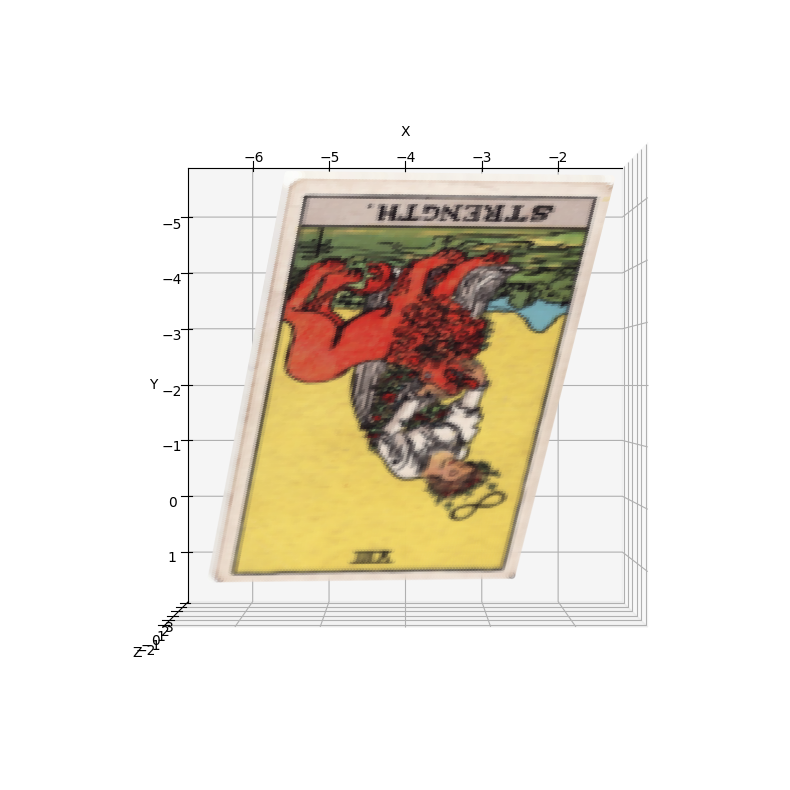

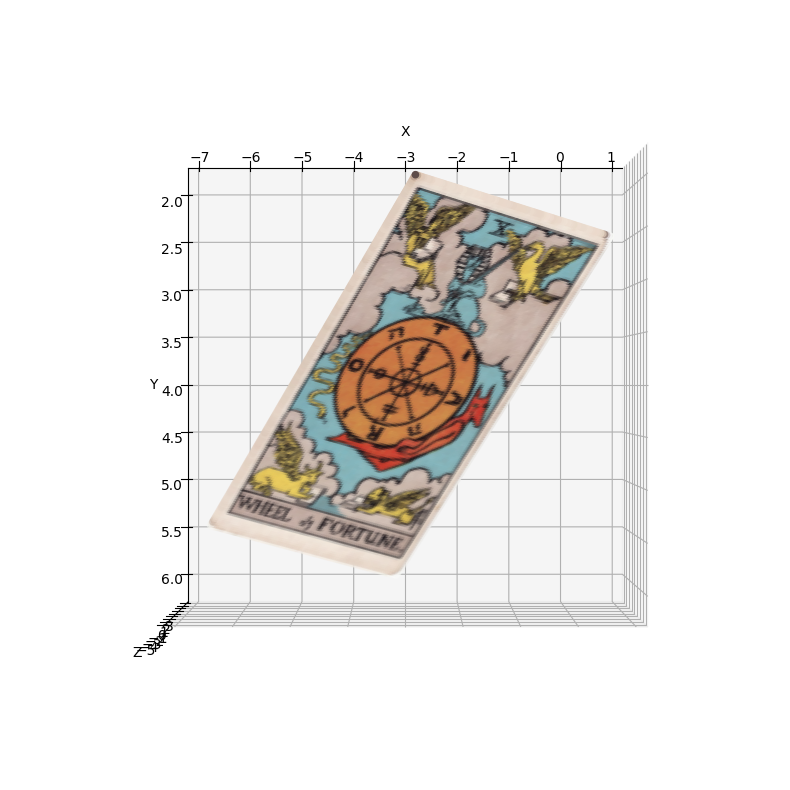

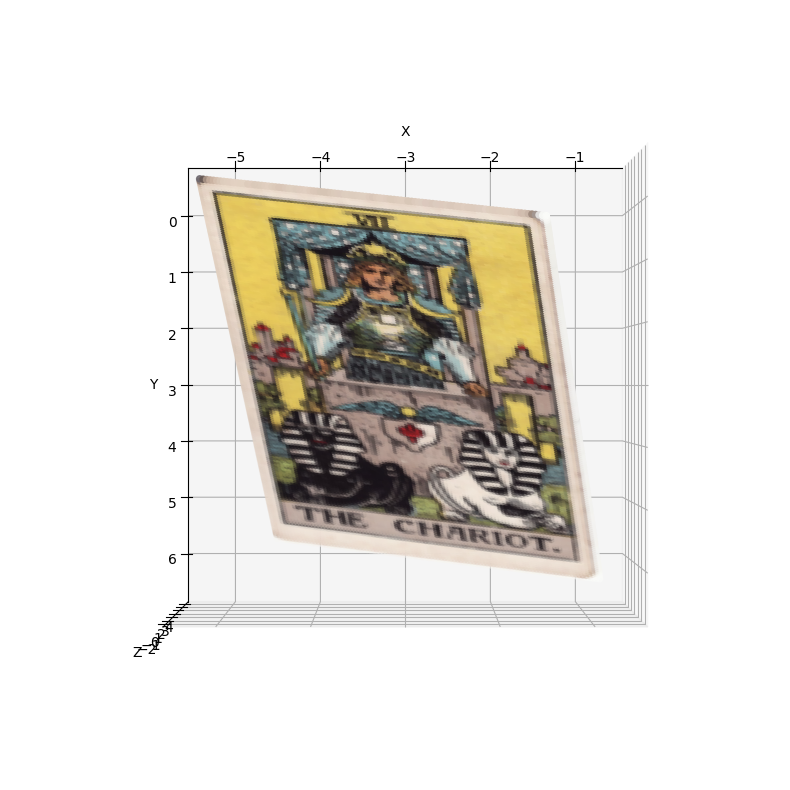

In [22]:
for tarot in tarots:
    visualize_pointcloud(tarot, -90, -90)

### Transform each card

In [23]:
from sklearn.decomposition import PCA

In [24]:
CCW90 = np.array([[0, -1],
                  [1,  0]])
CW90 = CCW90 @ CCW90 @ CCW90

In [169]:
def transform_to_2d(tarot, rotate_mat=np.identity(2)):
    pca = PCA(2)
    tarot_pca = pca.fit_transform(tarot[:, :3]) @ rotate_mat.T
    return np.concatenate([
        tarot_pca,
        np.zeros((tarot.shape[0], 1)),
        tarot[:, 3:]
    ], axis=1), pca

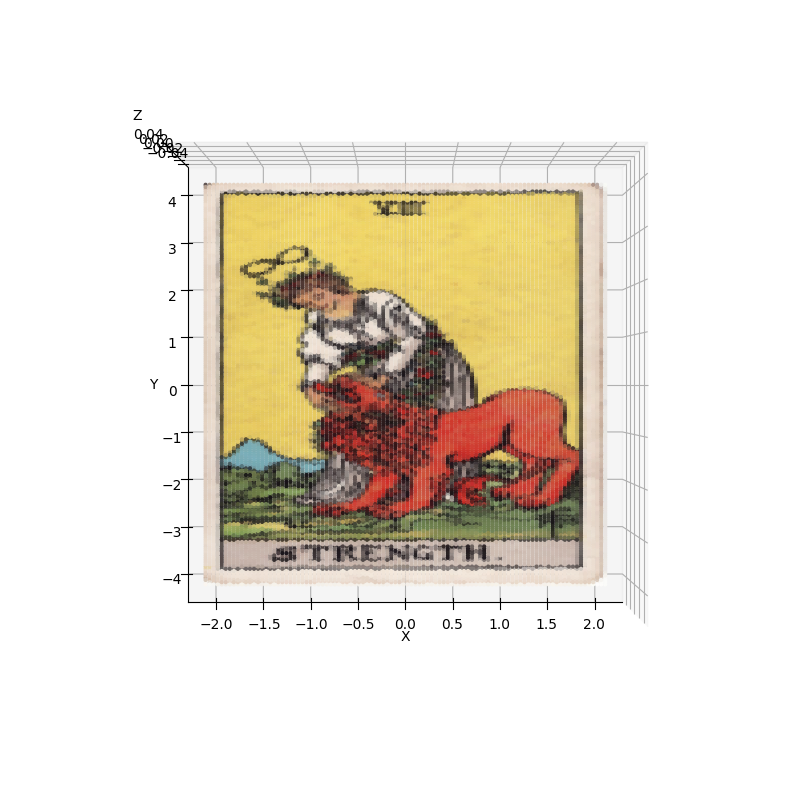

In [170]:
tarot0_pca, pca0 = transform_to_2d(tarots[0], CCW90)
visualize_pointcloud(tarot0_pca, elev=90, azim=-90, s=4)

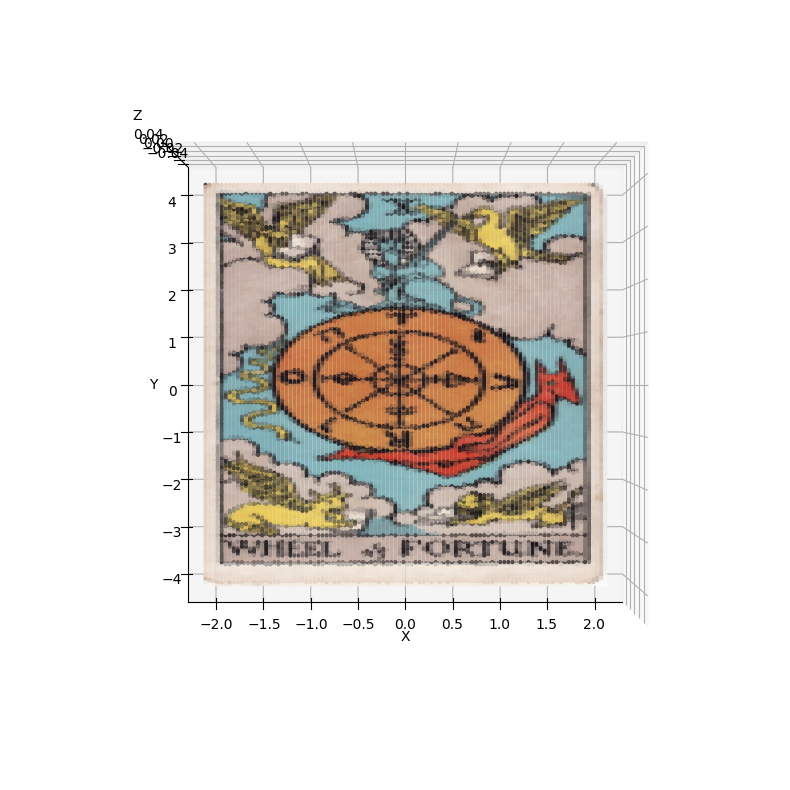

In [171]:
tarot1_pca, pca1 = transform_to_2d(tarots[1], CW90)
visualize_pointcloud(tarot1_pca, elev=90, azim=-90, s=4)

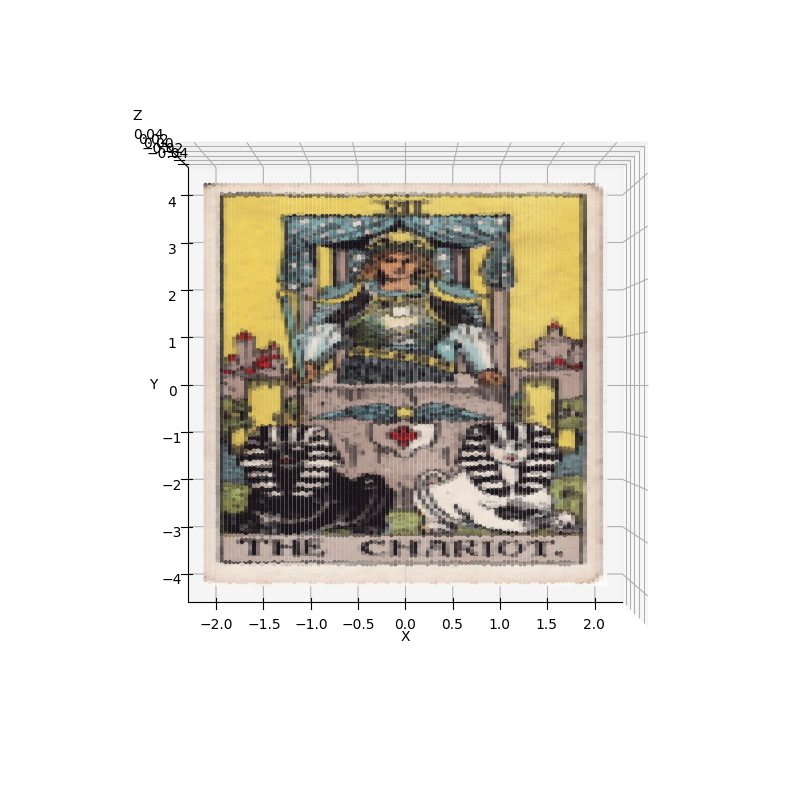

In [172]:
tarot2_pca, pca2 = transform_to_2d(tarots[2], CW90)
visualize_pointcloud(tarot2_pca, elev=90, azim=-90, s=4)

### Reconstruct the scene

In [179]:
def back_construct(tarot, pca_instance, plane_params, inv_rotate_mat=np.identity(2)):
    tarot_back = pca_instance.inverse_transform(tarot[:, :2] @ inv_rotate_mat.T)
    x, y = tarot_back[:, [0]], tarot_back[:, [1]]
    
    a, b, c = plane_params
    z = a * x + b * y + c

    return np.concatenate([
        x, y, z,
        tarot[:, 3:]
    ], axis=1)

In [180]:
tarot0_back = back_construct(tarot0_pca, pca0, planes[0], CW90)
tarot1_back = back_construct(tarot1_pca, pca1, planes[1], CCW90)
tarot2_back = back_construct(tarot2_pca, pca2, planes[2], CCW90)

tarot0_back.shape, tarot1_back.shape, tarot2_back.shape

((18000, 6), (18000, 6), (18000, 6))

In [181]:
tarots_back = np.vstack([
    tarot0_back,
    tarot1_back,
    tarot2_back,
])
tarots_back.shape

(54000, 6)

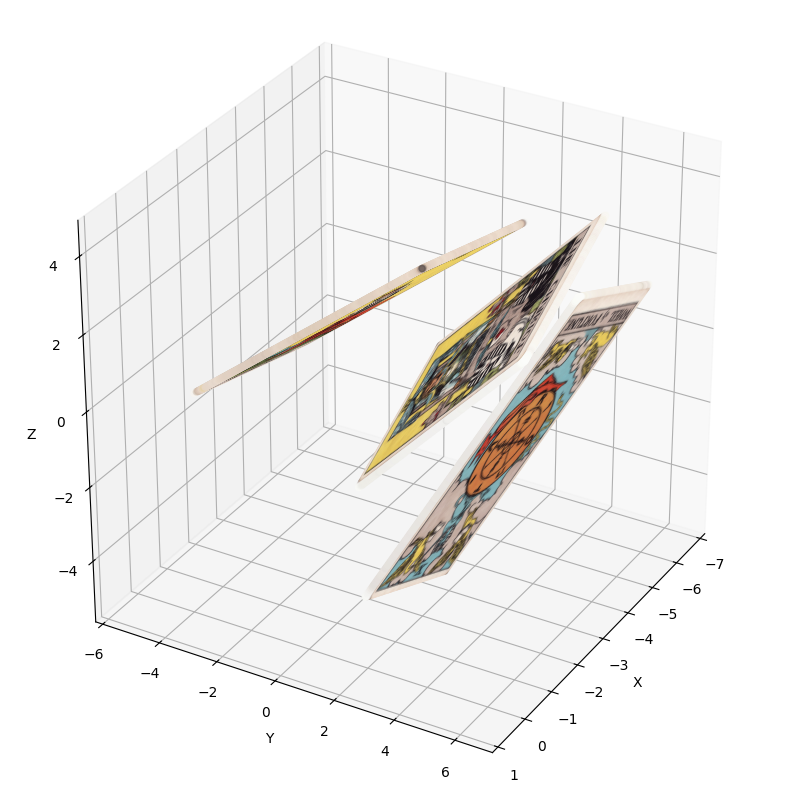

In [184]:
visualize_pointcloud(tarots_back)

### Explanation

For each point, we compute the average distance with 10 neighbours. The point is a noise if it is significantly away from other points. This threshold is determined by plotting a histogram. Then, we use HDBSCAN to segregate points into 3 tarot cards. The cards are finally orientated upright using PCA to get the principal 2D axes.

Back construction is done using the plane parameters we regress ahead: $z=ax+by+c$. We inverse transform the $x$s and $y$s. Finally, $z$s are reconstructed using the plane parameters $a$, $b$, and $c$.